# Figure generation for Supplementary figure 7

In [3]:
###### load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations, chain
from upsetplot import from_memberships
from scipy.stats import chi2, binomtest
from scipy import stats


# needed for editable text in svg format
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['text.usetex'] = False
plt.rcParams['svg.fonttype'] = 'none'


# import metadata
from M194_M220_metadata import *

%matplotlib inline

# Functions

## Processing

In [4]:
def clean_up_data(df_dirty, to_drop = ['OB', 'ACAi', 'ACAc', 'HIP'], inj_site="OMCi"):
    """Clean up datasets so all matrices are in the same format. Function 
        (1) drops unwanted columns, e.g. negative controls or dissections of other injection sites. 
        (2) renames RN (allen acronym) as BS (my brainstem acronym)
        (3) drops neurons w/ 0 projections after dropped columns

    Args:
        df_dirty (DataFrame): Pandas dataframe (neurons x area) that needs to be processed
        to_drop (list, optional): columns to drop. Defaults to ['OB', 'ACAi', 'ACAc', 'HIP'].
        inj_site (str, optional): Injection site. Defaults to "OMCi".

    Returns:
        DataFrame: Cleaned up data in dataframe format.
    """

    # 1. drop unused areas
    dropped = df_dirty.drop(to_drop, axis=1)

    # 2. change RN to bs
    replaced = dropped.rename(columns={'RN':'BS'})

    # 3. drop neurons w/ 0 projections after removing negative regions
    if type(inj_site)==str:
        nodes = replaced.drop([inj_site], axis=1).sum(axis=1)
    else:
        nodes = replaced.drop(inj_site, axis=1).sum(axis=1)
    
    n_idx = nodes > 0 # non-zero projecting neurons
    clean = replaced[n_idx]
    
    return clean



In [5]:
def sort_by_celltype(proj, it_areas=["OMCc", "AUD", "STR"], ct_areas=["TH"],
                      pt_areas=["AMY","HY","SNr","SCm","PG","PAG","BS"],
                      sort=True):
    """
    Function takes in projection matrix and outputs matrix sorted by the 3 major celltypes:
    - IT = intratelencephalic (projects to cortical and/or Striatum), type = 10
    - CT = corticalthalamic (projects to thalamus w/o projection to brainstem), type = 100
    - PT = pyramidal tract (projects to brainstem += other areas), type = 1000
    Returns single dataframe with cells sorted and labelled by 3 cell types (IT/CT/PT)

    Args:
        proj (DataFrame): pd.DataFrame of BC x area. Entries can be normalized BC or binary.
        it_areas (list, optional): Areas to determine IT cells. Defaults to ["OMCc", "AUD", "STR"].
        ct_areas (list, optional): Areas to determine CT cells. Defaults to ["TH"]. Don't actually use this...
        pt_areas (list, optional): Areas to determine PT cells. Defaults to ["AMY","HY","SNr","SCm","PG","PAG","BS"].
        sort (bool, optional): Whether to sort by cell type or return w/ original index. Defaults to True.
    
    Returns:
        df_out (DataFrame): Returns dataframe with extra column (type) labelled and sorted by cell type
    """
    
    ds=proj.copy()
 
    # Isolate PT cells
    pt_counts = ds[pt_areas].sum(axis=1)
    pt_idx = ds[pt_counts>0].index
    ds_pt = ds.loc[pt_idx,:]
    ds_pt['type'] = "PT"

    # Isolate remaining non-PT cells
    ds_npt = ds.drop(pt_idx)

    # Identify CT cells by thalamus projection
    th_idx = ds_npt['TH'] > 0
    ds_th = ds_npt[th_idx]
    if sort:
        ds_th = ds_th.sort_values('TH', ascending=False)
    ds_th['type'] = "CT"

    # Identify IT cells by the remaining cells (non-PT, non-CT)
    ds_nth = ds_npt[~th_idx]
    if sort:
        ds_nth = ds_nth.sort_values(it_areas,ascending=False)
    ds_nth['type'] = "IT"

    # combine IT and CT cells
    ds_npt = pd.concat([ds_nth, ds_th])

    # combine IT/CT and PT cells
    if sort:
        sorted = pd.concat([ds_npt,ds_pt],ignore_index=True)
        df_out=sorted.reset_index(drop=True)
    else:
        df_out = pd.concat([ds_npt,ds_pt]).sort_index()

    return(df_out)



In [6]:
def dfs_to_proportions(df_list, drop=["OMCi", "type"], keep=None, cell_type=None, meta=metadata, 
                       inj_site="OMCi", aud_rename=False):
    """Output dataframe of proportions in format that can be plotted with seaborn

    Args:
        df_list (list): 
            - List of dataframes of neurons/BC by areas
        drop (list, optional): 
            - Defaults to ["OMCi", "type"]
            - list of areas/columns to drop before calculating proportions
        cell_type (string, optional): 
            - Specify cell types in df, either IT, CT or PT
            - Defaults to None

    Returns:
        plot_df (pandas_dataframe):
            - returns dataframe in format for seaborn plotting
            - columns = areas, and other metadata
    """

    plot_df = pd.DataFrame(columns=["area", "proportion", "mice", "species", "dataset"])

    if cell_type == "IT":
        drop.extend([inj_site, 'TH', 'HY', 'AMY', 'SNr', 'SCm', 'PG',
       'PAG', 'BS'])
    elif cell_type == "PT":
        if aud_rename:
            drop.extend([inj_site,inj_site[:-1]+"c", 'AUD/TEa', "STR"])
        else:
            drop.extend([inj_site,inj_site[:-1]+"c", 'AUD', "STR"])

    if keep:
        drop = []

    mice = meta["mice"]
    species = meta["species"]
    dataset = meta["dataset"]

    for i in range(len(df_list)):
        df = df_list[i].drop(drop, axis=1)
        if keep:
            df = df.loc[:, keep] # just subset keep columns
        bc_sum = df.sum()
        proportion = bc_sum/df.shape[0]
        df_add = pd.DataFrame({"area":proportion.index.values, "proportion":proportion.values, 
        "mice":meta.loc[i,"mice"], "species":meta.loc[i,"species"], "dataset":meta.loc[i,"dataset"]})
        # add cell_type if specified
        if cell_type:
            df_add["type"] = cell_type
        plot_df = pd.concat([plot_df, df_add])
    
    return plot_df

In [7]:
def downsample_neurons(data, meta=metadata, random_state=10, species="MMus", sample_ns=None):
    """Given list of dataframe, sample from combined neurons/cells (with replacement), in equivalent numbers
    to singing mouse (or sample_ns) cells/brain. Returns list where each element is dataframe of neurons w/ numbers equivalent to ns.

    Args:
        data (list): List of pandas dataframes where each row is a different cell/neuron
        metadata (DataFrame, optional): Metadata used to determine which df in data is lab/singing mouse. 
                                        Defaults to metadata.
        random_state (int, optional): Set random state to use for repeatable sampling.
                                        Defaults to 10.
        species (str, optional): Species to sample. Defaults to "MMus".
        sample_ns (list, optional): List of int use as sample size per 'brain', if none defaults to singing mouse brain size.
                                         Defaults to None.
    """

    all = [data[i] for i in range(metadata.shape[0]) if metadata.loc[i,'species']==species]
    all = pd.concat(all).reset_index(drop=True)

    # print("mm_all.shape[0]", mm_all.shape[0])
    pool = all.copy()
    samp = []

    ns = []
    if sample_ns:
        ns = sample_ns
    else:
        # get steg sample neuron sizes
        for i in range(metadata.shape[0]):
            if metadata.loc[i,'species']=="STeg":
                ns.append(data[i].shape[0])


    for i in range(len(ns)):
        n = ns[i]
        int = pool.sample(n, random_state=random_state+i) # can't have same random_state for every round or will sample the same neurons

        samp.append(int.reset_index(drop=True))

    return(samp)

In [8]:
def statistic_testing(df, sp1="MMus", sp2="STeg", to_plot='proportion', 
                     groupby="area", test="ttest"):
    """output dataframe based on comparison of species individuals
        output dataframe can be used for making volcano plot

    Args:
        df (DataFrame): DataFrame of repeated values across species and inviduals.
        sp1 (str, optional): Group1 to use as comparison. Defaults to "MMus".
        sp2 (str, optional): Group1 to use as comparison. Defaults to "STeg".
        to_plot (str, optional): Column to calculate comparison. Defaults to 'proportion'.
        groupby (str, optional): Categories within to do comparison. Defaults to "area".
        test (str, optional): What test to use ["ttest", "mannwhitneyu"]. Defaults to "ttest".
    Returns:
        plot (DataFrame): pd.DataFrame w/ pvalues, means across species, and log. Can be used for volcano plot.
    """

    groups = sorted(df[groupby].unique())

    # sp1
    sp1_df = df[df["species"]==sp1]
    sp1_array = sp1_df.pivot_table(columns='mice', values=to_plot, index=groupby).values

    sp2_df = df[df["species"]==sp2]
    sp2_array = sp2_df.pivot_table(columns='mice', values=to_plot, index=groupby).values

    if test=="ttest":
        results = stats.ttest_ind(sp1_array, sp2_array, axis=1)
    elif test=="mannwhitneyu":
        results = stats.mannwhitneyu(sp1_array, sp2_array, axis=1)
    
    p_vals = results[1]
    plot = pd.DataFrame({groupby:groups, "p-value":p_vals})
    plot[sp1+"_mean"] = sp1_array.mean(axis=1)
    plot[sp1+"_sem"] = stats.sem(sp1_array, axis=1)
    plot[sp2+"_mean"] = sp2_array.mean(axis=1)
    plot[sp2+"_sem"] = stats.sem(sp2_array, axis=1)
    # plot["effect_size"] = (plot["st_mean"]-plot["mm_mean"]) / (plot["st_mean"] + plot["mm_mean"]) # modulation index
    plot["fold_change"] = plot[sp2+"_mean"]/(plot[sp1+"_mean"])
    plot["log2_fc"] = np.log2(plot["fold_change"])
    plot["nlog10_p"] = -np.log10(plot["p-value"])
    plot["p<0.05"] = plot["p-value"]<0.05

    return(plot)

In [9]:
def estimate_n_total(df, plot_areas):
    """Calculate estimated N_total based on observed number of neuron per areas.
       Works with IT and PT areas with as many areas as wanted. See Han et al., 2017
       for more detail/formula.

    Args:
        df (DataFrame): Binary matrix of BC x areas
        areas (list): List of areas using to calculat motifs. Should be list of strings.
    Returns:
        n_total (int): Estimated n total for input data.
    """
    n_obs = df.shape[0]
    n_areas = df.sum()
    all_terms = []
    for k in range(1, len(plot_areas)+1):
        combos = list(combinations(plot_areas, k))
        term = 0
        for i in range(len(combos)):
            product = 1
            for j in range(len(combos[i])):
                n_area = n_areas[combos[i][j]]
                product = product*n_area
            term = term + product
        all_terms.append(term)

    # need to subtract first term from n_obs
    all_terms[0] = n_obs - all_terms[0]

    # multiply every other by -1 starting w/ 3rd term
    for l in range(len(all_terms)):
        if l>=2 and l%2==0:
            all_terms[l] = -1*all_terms[l]

    # find roots of polynomial
    roots = np.roots(all_terms)

    # convert to real numbers if numbers complex
    if isinstance(roots[0],complex):
        reals = []
        for num in roots:
            if num.imag==0:
                reals.append(num.real)
    else:
        reals = roots.copy()

    # pick root that is more than n_obs
    # if can't find root more than n_obs, return n_obs as n_total
    n_total = n_obs
    for num in reals:
        if num > n_obs:
            n_total = round(num)

    return(n_total)

In [10]:
def df_to_motif_proportion(df, areas, proportion=True, subset=None):
    """Make series to feed into upset plot based on given data and area list

    Args:
        df (pd.DataFrame): df containing bc x area
        areas (list): List of areas (str) to be plotted
        proportion (bool, optional): Whether to output counts or proportions. Defaults to True.
        subset (str, optional): Whether to subset on certain brain area (e.g. 'PAG'). Defaults to None.
    Returns:
        plot_s (DataFrame): dataframe of proprotion/count of each motif for input data.
    """

    # generate all combinations of areas in true/false list
    area_comb = []
    for i in range(len(areas)):
        n = i+1
        area_comb.append(list(combinations(areas, n)))

    area_comb_list = list(chain.from_iterable(area_comb)) # flatten list
    memberships = from_memberships(area_comb_list) # generate true/false
    area_comb_TF = memberships.index.values # extract array w/ true/false values
    area_comb_names = memberships.index.names # get order of areas

    # calculate number of neurons of each motif
    comb_count = []
    for tf in area_comb_TF:
        neurons = df
        for i in range(len(area_comb_names)):
            # subset dataset on presence/absence of proj
            neurons = neurons[neurons[area_comb_names[i]]==tf[i]]
        if proportion: # return proportion
            comb_count.append(neurons.shape[0]/df.shape[0])
        else: # return count
            comb_count.append(neurons.shape[0])

    plot_s = from_memberships(area_comb_list, data=comb_count)

    if subset:
        motif_areas = plot_s.index.names
        subset_idx = motif_areas.index(subset)
        idx = [i for i, x in enumerate(plot_s.index) if x[subset_idx]]
        plot_s = plot_s[idx]

    return(plot_s)

In [11]:
def df_to_motif_estimated_proportions(data, combinations, adjust_total=False):
    """Given dataframe of cells and index of combinations (generated from df_to_motif_prportions),
    return series similar to output for df_to_motif_proportions. Proportions are estimated
    by multiplying the bulk/population proporitons/probabilities.

    Args:
        data (DataFrame): DataFrame of BC x areas, binary
        combinations (MultiIndex): Index from output of df-to_motif_proportions
        adjust_total (bool): whether to adjust the matrix w/ unobserved neurons. Defaults to False.
    Returns:

    """

    # adjust n_total (add in 0 projectors), if not done
    if adjust_total:
        # calculate n_total
        n_obs = data.shape[0]
        n_total = estimate_n_total(data, combinations.names)
        n_unobs = np.array(n_total )- np.array(n_obs)
        unobs_df = pd.DataFrame(0, index=np.arange(n_unobs), columns=data.columns)
        df = pd.concat([data, unobs_df]).reset_index(drop=True)
    else:
        df = data.copy()

    # get brain areas specified in combinations
    names = list(combinations.names)
    
    # subset df to just columns used in motifs
    df_subset = df.loc[:,names]

    # get bulk proportions across those areas
    bulk_prop = df_subset.sum(axis=0)/df.shape[0]

    # calculate expected motif proportion based on product of bulk proportions
    expected_proportions = []
    names = combinations.names
    for i in range(combinations.shape[0]):
        motif = combinations[i]
        product = 1

    
        for j in range(len(names)):
            if motif[j]: # if area in motif, multiply by bulk probability
                product = product * bulk_prop[names[j]]
            else: # if area not in motif, multiply by 1-bulk probability (chance of not projecting to area)
                product = product * (1-bulk_prop[names[j]])
        
        expected_proportions.append(product)

    motif_expected_prop = pd.Series(expected_proportions, index=combinations)

    return(motif_expected_prop)

In [12]:
def TF_to_motifs(index):
    """Generate motif strings from True/False MultiIndex genreated by df_to_motif_proportion()

    Args:
        index (MultiIndex): True/False for area combinations
    Returns:
        array of strings for area combinations
    """
   
    motifs_strings = []
    for r in index:
        motif = ""
        for i in range(len(index.names)):
            if r[i]:
                motif = motif+index.names[i]+"_"
        motifs_strings.append(motif)

    return(motifs_strings)

## Plotting

In [13]:
def dot_plot(data, subset=None, title=None, err="se", add_legend=False,
                              to_plot="proportion", ylim=(0), fig_size=(3.5,3.5),
                              jitter=False, alpha=0.3):
    """Plot closed circle of value per area for data.

    Args:
        data (DataFrame): Dataframe of proportions, included downsampled data.
        subset (list, optional): List of what to subset on to plot. Defaults to None.
        title (str, optional): Title for plot. Defaults to None.
        err (str, optional): Error to plot, can be "ci", "pi", "se", or "sd". Defaults to "se".
        add_legend (bool, optional): Whether to add legend labeling mean/err. Defaults to False.
        to_plot (str, optional): Column to plot. Defaults to "proportion".
        ylim (tuple, optional): lower bound for yaxis. Defaults to (0).
        fig_size (tuple, optional): Dimensions (in inches) of plot. Defaults to (3.5,3.5).
        jitter (bool, optional): Whether to have overlapping points. Defaults to False.
        alpha (float, optional): How much transparency for points. Defaults to 0.3.
    """

    if subset:
        df = data[data[subset[0]]==subset[1]]
    else:
        df = data.copy()

    fig, ax = plt.subplots()

    sns.stripplot(x='species', y=to_plot, hue="species",
                   dodge=False, data=df, jitter=jitter, 
                   size=10, alpha=alpha)
    sns.pointplot(df, x="species", y=to_plot, hue="species",
              dodge=False, marker="+", 
              ls="", zorder=10, errorbar="se")



    ax.set_xlabel("")

    plt.title(title, size=20)
    plt.ylim(ylim) # make sure y axis starts at 0
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # set figure size
    fig = plt.gcf()
    fig.set_size_inches(fig_size[0],fig_size[1])

    if add_legend:
        legend = mlines.Line2D([], [], color="black", marker="[]", linewidth=0, label="mean, "+err)
        plt.legend(handles=[legend], loc="lower right")
    else:
        plt.legend([],[], frameon=False)


    return(fig)

In [14]:
def plot_volcano(df, x="log2_fc", y="nlog10_p", title=None, labels="area", shape=None,
                 p_05=True, p_01=True, p_bf=None, xlim=(-2,2), ylim=(0,-np.log10(0.02)), 
                 legend_loc="upper left", fig_size=(4,4), color=None, alpha=None,
                 marker_size=25):
    """output volcano plot based on comparison of species proportional means

    Args:
        df (pd.DataFrame): output of proprotion_ttest
        x (str): column name to put on x axis
        y (str): column name to put on y axis
        title (str, optional): title of plot. Defaults to None
        labels (str, optional): column used to label points. Defaults to 'area'.
        shape (str, optional): Column used to determine shape (e.g. 'type'). Defaults to None.
        p_05 (bool, optionl): used to toggle p<05 line on/off. Defaults to Ture.
        p_01 (bool, optionl): used to toggle p<01 line on/off. Defaults to Ture.
        p_bf (float, optional): Boferoni correction cut-off to plot. Defaults to None.
        xlim (tuple, optional): tuple of numbers to set x-axis limits. Defaults to (-2,2).
    """

    # areas = sorted(df['area'].unique())

    fig = plt.subplot()

    marker_order = ['o', 'D', 'v']
    color_order = ["#2ca02c", "#9467bd"]
    if shape:
        nshapes = df[shape].unique()
        for i in range(nshapes.shape[0]):
            dfn = df[df[shape]==nshapes[i]]
            plt.scatter(dfn[x], dfn[y], label=nshapes[i],
                        marker=marker_order[i], s=marker_size, c=color_order[i])
        

        # #  Create custom legend labels
        # point1 = line2D([0], [0], label=)

        # # Create custom legend markers using patches
        # circle_marker = mpatches.Patch(color='black', marker='o', label=legend_labels[0])
        # diamond_marker = mpatches.Patch(color='black', marker='D', label=legend_labels[1])

        # # Create a custom legend using handles and labels
        # plt.legend(handles=[circle_marker, diamond_marker], labels=legend_labels, loc='upper right')

    else:
        plt.scatter(df[x],df[y], s=marker_size, c=color, alpha=alpha)


    # plt.xlim([-1,1])
    # plt.ylim([-0.1,4])
    # plot 0 axes
    plt.axline((0, 0), (0, 1),linestyle='--', color="grey", alpha=0.3, linewidth=0.5)
    plt.axline((0, 0), (1, 0),linestyle='--', color="grey", alpha=0.3, linewidth=0.5)

    # p_value cut-offs
    if p_05:
        plt.axline((0, -np.log10(0.05)), (1,  -np.log10(0.05)),linestyle='--', color='r', alpha=0.75, linewidth=0.5)
        plt.text(-0.1, -np.log10(0.05)+.015, 'p<0.05', color='r', alpha=0.3)
    if p_01:
        plt.axline((0, -np.log10(0.01)), (1,  -np.log10(0.01)),linestyle='--', color='r', alpha=0.5, linewidth=0.5)
        plt.text(-0.1, -np.log10(0.01)+.015, 'p<0.01', color='r', alpha=0.3)
    if p_bf:
        plt.axline((0, -np.log10(p_bf)), (1,  -np.log10(p_bf)),linestyle='--', color='r', alpha=0.75, linewidth=0.5)
        plt.text(-0.1, -np.log10(p_bf)+.015, 'p<bf_01', color='r', alpha=0.3)


    for i in range(df.shape[0]):
        plt.text(x=df.loc[i,x]+0.01,y=df.loc[i,y]+0.01,s=df.loc[i, labels], 
            fontdict=dict(color='black',size=10))


    plt.title(title, pad=12)
    # plt.xlabel('log2(fold change)')
    if x=="log2_fc":
        plt.xlabel('$log_{2}$($\dfrac{STeg}{MMus}$)')
    elif x=="fold_change":
        plt.xlabel(r'$\dfrac{STeg}{MMus}$')
    plt.ylabel('$-log_{10}(p\ value)$')

    if legend_loc:
        handles, labels = plt.gca().get_legend_handles_labels()
        plt.legend(handles=handles, loc=legend_loc)


    # apply axis limits
    plt.xlim(xlim)
    plt.ylim(ylim)

    # hide top and right axis
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.rcParams.update({'font.size': 12})

    # set figure size
    fig = plt.gcf()
    fig.set_size_inches(fig_size[0],fig_size[1])


    return(fig)

<>:74: SyntaxWarning: invalid escape sequence '\d'
<>:77: SyntaxWarning: invalid escape sequence '\ '
<>:74: SyntaxWarning: invalid escape sequence '\d'
<>:77: SyntaxWarning: invalid escape sequence '\ '
/var/folders/l2/gvq0gkm95b1fbrlls4tsq2wr0000gp/T/ipykernel_11012/3308567497.py:74: SyntaxWarning: invalid escape sequence '\d'
  plt.xlabel('$log_{2}$($\dfrac{STeg}{MMus}$)')
/var/folders/l2/gvq0gkm95b1fbrlls4tsq2wr0000gp/T/ipykernel_11012/3308567497.py:77: SyntaxWarning: invalid escape sequence '\ '
  plt.ylabel('$-log_{10}(p\ value)$')


# Load data


In [15]:
# Paths and load data
in_path = '/Volumes/Data/Emily/MAPseq/combined_analysis_M194_M220/processed_data/'
# out_path = '/Volumes/Data/Emily/figures/fig_3_sc/python_out/'
# out_path = '/Volumes/Data/Emily/figures/fig_2_mapseq/figure_pics/'
out_path = "/Users/eisko/Documents/CSHL/mapseq_paper/svg_images/"

#### load data - OMC
omc_bin = pd.read_pickle(in_path+"M194_M220_OMC_bin.pkl")


# bin processing
omc_clean = [clean_up_data(df) for df in omc_bin]
omc_type = [sort_by_celltype(df) for df in omc_clean]

# seperate it cells
omc_it = [df[df['type']=="IT"] for df in omc_type]

# Downsampling proportions

In [16]:
# seperate binarized counts into celltypes
it_bin = [df[df["type"]=="IT"].reset_index(drop=True) for df in omc_type]
pt_bin = [df[df["type"]=="PT"].reset_index(drop=True) for df in omc_type]

it_areas = ["OMCc", "AUD", "STR"]
pt_areas = ["TH", "HY", "AMY", "PAG", "SNr", "SCm", "PG", "BS"]

# calculate area proprotions
it_prop = dfs_to_proportions(it_bin, cell_type="IT", drop=["OMCi", "type"])
pt_prop = dfs_to_proportions(pt_bin, cell_type="PT", drop=["OMCi", "type"])

/var/folders/l2/gvq0gkm95b1fbrlls4tsq2wr0000gp/T/ipykernel_11012/1941326770.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_df = pd.concat([plot_df, df_add])
/var/folders/l2/gvq0gkm95b1fbrlls4tsq2wr0000gp/T/ipykernel_11012/1941326770.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_df = pd.concat([plot_df, df_add])


In [17]:
# downsample mmus neurons
mmus_down_meta = pd.DataFrame({"mice":["mm_down1", "mm_down2", "mm_down3", "mm_down4", 
                                       "mm_down5", "mm_down6", "mm_down7"],
                                "species":["MMus\ndownsample"]*7, 
                                "dataset":["aggregate"]*7})
it_mmus_down = downsample_neurons(it_bin)
pt_mmus_down = downsample_neurons(pt_bin)

# calculate proportions
it_mm_down_prop = dfs_to_proportions(it_mmus_down, cell_type="IT", drop=["OMCi", "type"], 
                                     meta=mmus_down_meta)
pt_mm_down_prop = dfs_to_proportions(pt_mmus_down, cell_type="PT", drop=["OMCi", "type"], 
                                     meta=mmus_down_meta)

# add to proportion dataframes
it_prop_all = pd.concat([it_prop, it_mm_down_prop])
pt_prop_all = pd.concat([pt_prop, pt_mm_down_prop])

/var/folders/l2/gvq0gkm95b1fbrlls4tsq2wr0000gp/T/ipykernel_11012/1941326770.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_df = pd.concat([plot_df, df_add])
/var/folders/l2/gvq0gkm95b1fbrlls4tsq2wr0000gp/T/ipykernel_11012/1941326770.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_df = pd.concat([plot_df, df_add])


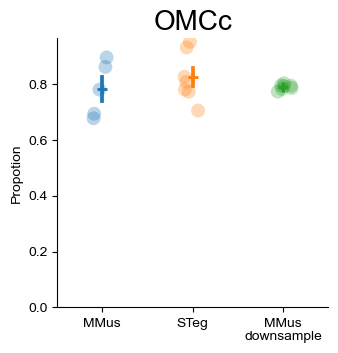

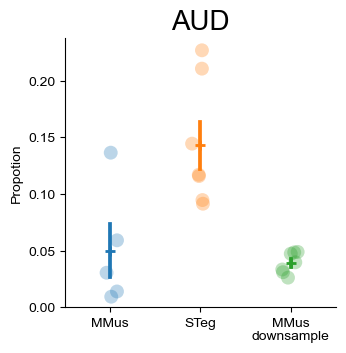

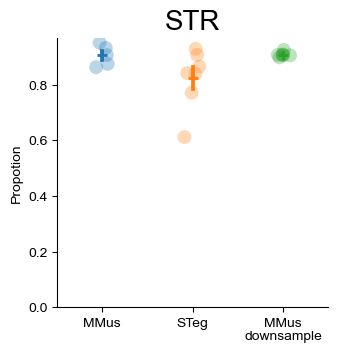

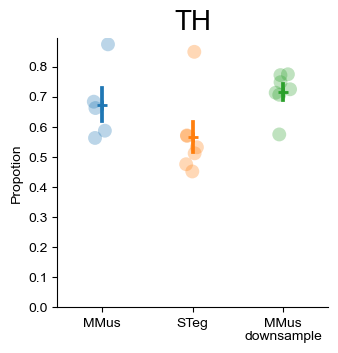

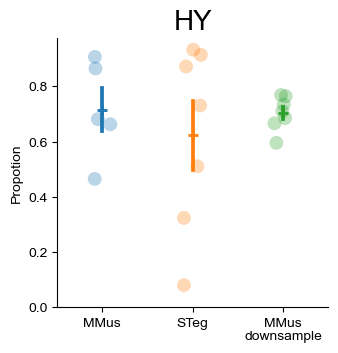

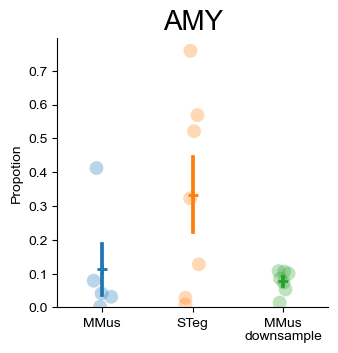

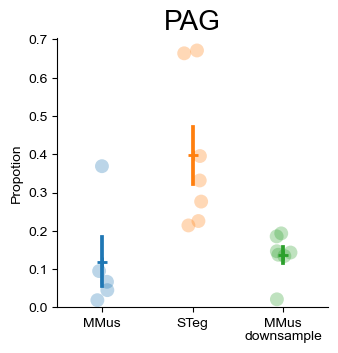

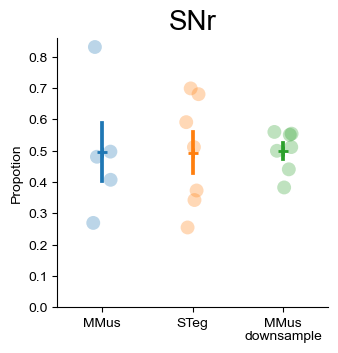

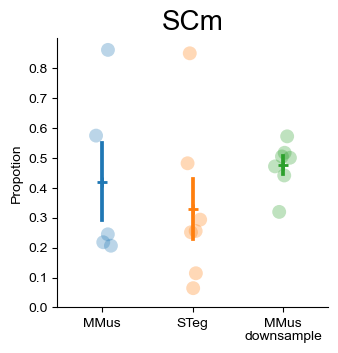

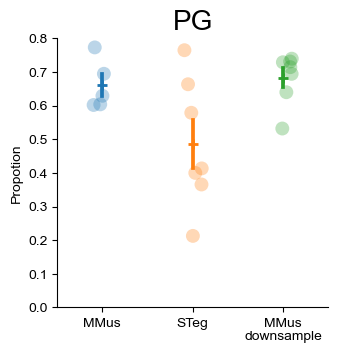

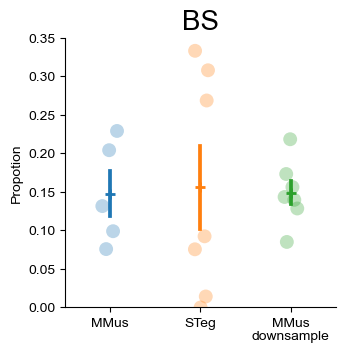

In [18]:
# plot downsampled dot plots

# plot it areas
for area in it_areas:
    dot_plot(it_prop_all, subset=["area",area], title=area, add_legend=False,
             jitter=True)
    plt.ylabel("Propotion")
    # plt.savefig(out_path+"OMC_"+area+"_proportion_dot_downsample.svg", dpi=300, bbox_inches="tight")
    plt.show()

# plot pt areas
for area in pt_areas:
    dot_plot(pt_prop_all, subset=["area",area], title=area, add_legend=False,
             jitter=True)
    plt.ylabel("Propotion")
    # plt.savefig(out_path+"OMC_"+area+"_proportion_dot_downsample.svg", dpi=300, bbox_inches="tight")
    plt.show()

In [19]:
# significance testing - IT
print("\nMANNWHITNEYU - mmus v. steg")
mannwhitney = statistic_testing(it_prop_all, test="mannwhitneyu", sp1="MMus", sp2="STeg")
display(mannwhitney)

print("\nMANNWHITNEYU - mmus downsample v. steg")
mannwhitney = statistic_testing(it_prop_all, test="mannwhitneyu", sp1="MMus\ndownsample", sp2="STeg")
display(mannwhitney)



MANNWHITNEYU - mmus v. steg


,area,p-value,MMus_mean,MMus_sem,STeg_mean,STeg_sem,fold_change,log2_fc,nlog10_p,p<0.05
0,AUD,0.030303,0.050002,0.023315,0.143009,0.020696,2.860087,1.516059,1.518514,True
1,OMCc,0.431818,0.780523,0.043465,0.823807,0.033262,1.055454,0.077864,0.364699,False
2,STR,0.106061,0.905569,0.016619,0.823819,0.040202,0.909725,-0.136498,0.974446,False



MANNWHITNEYU - mmus downsample v. steg


,area,p-value,MMus\ndownsample_mean,MMus\ndownsample_sem,STeg_mean,STeg_sem,fold_change,log2_fc,nlog10_p,p<0.05
0,AUD,0.000583,0.039400,0.003505,0.143009,0.020696,3.629650,1.859830,3.234517,True
1,OMCc,0.620047,0.788267,0.003638,0.823807,0.033262,1.045086,0.063622,0.207576,False
2,STR,0.097319,0.908267,0.003054,0.823819,0.040202,0.907022,-0.140790,1.011801,False


In [20]:
# significance testing - PT
print("\nMANNWHITNEYU - mmus v. steg")
mannwhitney = statistic_testing(pt_prop_all, test="mannwhitneyu", sp1="MMus", sp2="STeg")
display(mannwhitney)

print("\nMANNWHITNEYU - mmus downsample v. steg")
mannwhitney = statistic_testing(pt_prop_all, test="mannwhitneyu", sp1="MMus\ndownsample", sp2="STeg")
display(mannwhitney)



MANNWHITNEYU - mmus v. steg


,area,p-value,MMus_mean,MMus_sem,STeg_mean,STeg_sem,fold_change,log2_fc,nlog10_p,p<0.05
0,AMY,0.267677,0.113423,0.075764,0.333813,0.110531,2.943087,1.557330,0.572389,False
1,BS,0.876263,0.148019,0.029696,0.156069,0.053946,1.054388,0.076406,0.057366,False
2,HY,1.000000,0.716386,0.079205,0.623762,0.124478,0.870707,-0.199740,-0.000000,False
3,PAG,0.030303,0.119106,0.063729,0.397023,0.073663,3.333369,1.736981,1.518514,True
4,PG,0.106061,0.660502,0.032763,0.485515,0.072310,0.735070,-0.444046,0.974446,False
5,SCm,0.876263,0.420469,0.129390,0.329837,0.100260,0.784452,-0.350244,0.057366,False
6,SNr,1.000000,0.497362,0.092619,0.493500,0.065661,0.992236,-0.011245,-0.000000,False
7,TH,0.073232,0.673726,0.054779,0.565792,0.050081,0.839796,-0.251890,1.135297,False



MANNWHITNEYU - mmus downsample v. steg


,area,p-value,MMus\ndownsample_mean,MMus\ndownsample_sem,STeg_mean,STeg_sem,fold_change,log2_fc,nlog10_p,p<0.05
0,AMY,0.159864,0.077393,0.012848,0.333813,0.110531,4.313215,2.108764,0.796249,False
1,BS,0.798298,0.149314,0.015499,0.156069,0.053946,1.045241,0.063835,0.097835,False
2,HY,1.000000,0.703714,0.023048,0.623762,0.124478,0.886387,-0.173992,-0.000000,False
3,PAG,0.002165,0.137601,0.021330,0.397023,0.073663,2.885313,1.528728,2.664536,True
4,PG,0.073638,0.682860,0.028209,0.485515,0.072310,0.711002,-0.492074,1.132896,False
5,SCm,0.073638,0.474763,0.030070,0.329837,0.100260,0.694741,-0.525452,1.132896,False
6,SNr,1.000000,0.500229,0.025142,0.493500,0.065661,0.986548,-0.019539,-0.000000,False
7,TH,0.029842,0.715937,0.025674,0.565792,0.050081,0.790282,-0.339560,1.525171,True


# Downsampling motifs

In [21]:
# calculate estimates for motifs

plot_areas = ["OMCc", "AUD", "STR"]

# Estimate n-totals
n_totals = [estimate_n_total(omc_it[i], plot_areas) for i in range(len(omc_it))]

# Count obs motifs
n_obs_motifs = [df_to_motif_proportion(df, areas=plot_areas, proportion=False) for df in omc_it]
motifs = n_obs_motifs[0].index

# convert to proportions using adjusted n_totals
p_obs_motifs = [n_obs_motifs[i]/n_totals[i] for i in range(len(n_totals))]

# calculate expected proportions based on independent bulk probabilities adjusted for n_total
p_expected_motifs = [df_to_motif_estimated_proportions(df, motifs, adjust_total=True) for df in omc_it]

motif_strings = TF_to_motifs(motifs)

# put into dataframe - note p_obs is adjusted for n_total
it_motifs_df = []
for i in range(len(n_totals)):
    df = pd.DataFrame({"motifs":motif_strings, "n_shape":omc_it[i].shape[0], "n_total":n_totals[i],
                  "n_obs":n_obs_motifs[i], "p_obs":p_obs_motifs[i], "p_exp":p_expected_motifs[i],
                  "mice":metadata.loc[i,"mice"], "species":metadata.loc[i,"species"]})
    it_motifs_df.append(df)
it_motifs_df = pd.concat(it_motifs_df).reset_index(drop=True)

it_motifs_df

,motifs,n_shape,n_total,n_obs,p_obs,p_exp,mice,species
0,OMCc_,8287,8949,1123,0.125489,0.124100,MMM1,MMus
1,AUD_,8287,8949,3,0.000335,0.000980,MMM1,MMus
2,STR_,8287,8949,2668,0.298134,0.294598,MMM1,MMus
3,AUD_OMCc_,8287,8949,8,0.000894,0.001644,MMM1,MMus
4,OMCc_STR_,8287,8949,4379,0.489328,0.494259,MMM1,MMus
...,...,...,...,...,...,...,...,...
79,STR_,527,530,29,0.054717,0.053811,STM7,STeg
80,AUD_OMCc_,527,530,9,0.016981,0.018997,STM7,STeg
81,OMCc_STR_,527,530,351,0.662264,0.659190,STM7,STeg
82,AUD_STR_,527,530,4,0.007547,0.014256,STM7,STeg


In [22]:
# downsample MMus and calculate motif proportions
# downsample
mmus_down_meta = pd.DataFrame({"mice":["mm_down1", "mm_down2", "mm_down3", "mm_down4", 
                                       "mm_down5", "mm_down6", "mm_down7"],
                                "species":["MMus\ndownsample"]*7, 
                                "dataset":["aggregate"]*7})
it_mmus_down = downsample_neurons(omc_it)

In [23]:
# calculate estimates for motifs

plot_areas = ["OMCc", "AUD", "STR"]

# Estimate n-totals
n_totals = [estimate_n_total(it_mmus_down[i], plot_areas) for i in range(len(it_mmus_down))]

# Count obs motifs
n_obs_motifs = [df_to_motif_proportion(df, areas=plot_areas, proportion=False) for df in it_mmus_down]
motifs = n_obs_motifs[0].index

# convert to proportions using adjusted n_totals
p_obs_motifs = [n_obs_motifs[i]/n_totals[i] for i in range(len(n_totals))]

# calculate expected proportions based on independent bulk probabilities adjusted for n_total
p_expected_motifs = [df_to_motif_estimated_proportions(df, motifs, adjust_total=True) for df in it_mmus_down]

motif_strings = TF_to_motifs(motifs)

# put into dataframe - note p_obs is adjusted for n_total
it_motifs_df_mmd = []
for i in range(len(n_totals)):
    df = pd.DataFrame({"motifs":motif_strings, "n_shape":it_mmus_down[i].shape[0], "n_total":n_totals[i],
                  "n_obs":n_obs_motifs[i], "p_obs":p_obs_motifs[i], "p_exp":p_expected_motifs[i],
                  "mice":mmus_down_meta.loc[i,"mice"], "species":mmus_down_meta.loc[i,"species"]})
    it_motifs_df_mmd.append(df)
it_motifs_df_mmd = pd.concat(it_motifs_df_mmd).reset_index(drop=True)

# it_motifs_df_mmd

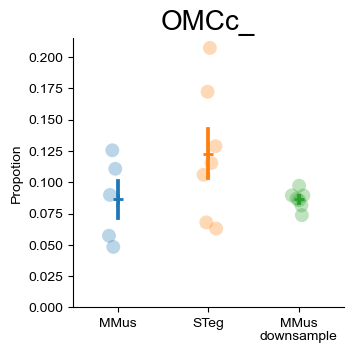

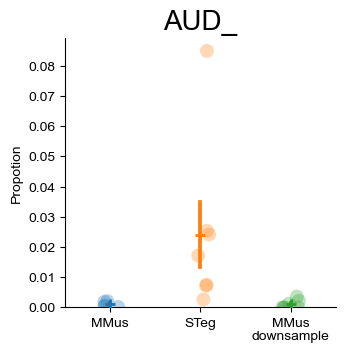

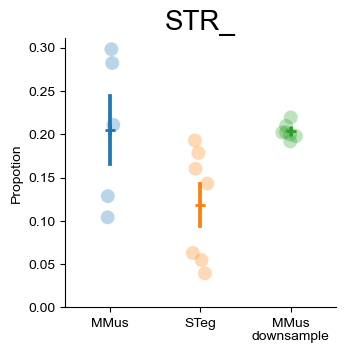

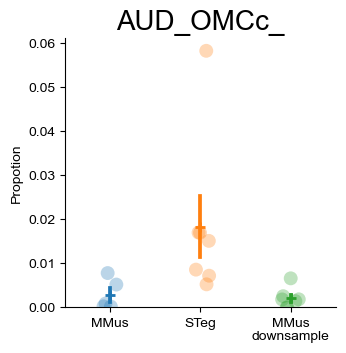

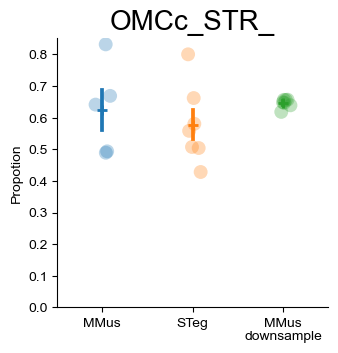

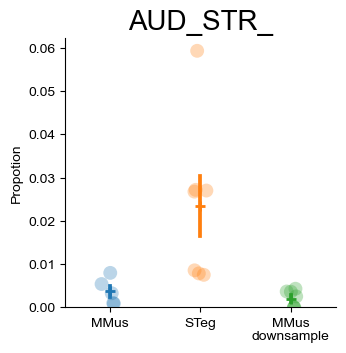

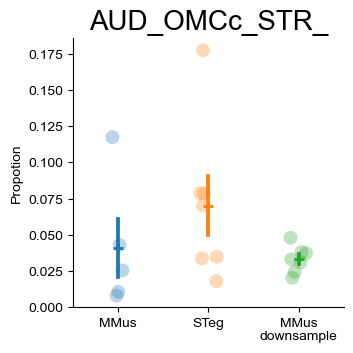

In [24]:
# plot
plot_df = pd.concat([it_motifs_df, it_motifs_df_mmd])

for motif in motif_strings:
    dot_plot(plot_df, subset=["motifs",motif], to_plot="p_obs", title=motif, add_legend=False,
             jitter=True)
    plt.ylabel("Propotion")
    # plt.savefig(out_path+"OMC_"+motif+"_proportion_dot_downsample.svg", dpi=300, bbox_inches="tight")
    plt.show()

In [26]:
# Significance testing
print("\nMANNWHITNEYU - mmus v. steg")
mannwhitney = statistic_testing(plot_df, to_plot="p_obs", groupby="motifs", test="mannwhitneyu", sp1="MMus", sp2="STeg")
display(mannwhitney)

print("\nMANNWHITNEYU - mmus downsample v. steg")
mannwhitney = statistic_testing(plot_df, to_plot="p_obs", groupby="motifs", test="mannwhitneyu", sp1="MMus\ndownsample", sp2="STeg")
display(mannwhitney)



MANNWHITNEYU - mmus v. steg


,motifs,p-value,MMus_mean,MMus_sem,STeg_mean,STeg_sem,fold_change,log2_fc,nlog10_p,p<0.05
0,AUD_,0.002525,0.001041,0.000400,0.024160,0.010665,23.214908,4.536980,2.597695,True
1,AUD_OMCc_,0.010101,0.002869,0.001544,0.018326,0.006891,6.386662,2.675062,1.995635,True
2,AUD_OMCc_STR_,0.267677,0.041023,0.020097,0.070286,0.020060,1.713316,0.776792,0.572389,False
3,AUD_STR_,0.010101,0.003724,0.001353,0.023474,0.006971,6.303538,2.656162,1.995635,True
4,OMCc_,0.202020,0.086338,0.014876,0.122906,0.019840,1.423539,0.509482,0.694605,False
5,OMCc_STR_,0.755051,0.625158,0.063530,0.577482,0.046235,0.923738,-0.114445,0.122024,False
6,STR_,0.148990,0.204746,0.039174,0.118758,0.024332,0.580027,-0.785808,0.826843,False



MANNWHITNEYU - mmus downsample v. steg


,motifs,p-value,MMus\ndownsample_mean,MMus\ndownsample_sem,STeg_mean,STeg_sem,fold_change,log2_fc,nlog10_p,p<0.05
0,AUD_,0.002962,0.001013,0.000545,0.024160,0.010665,23.845127,4.575623,2.528436,True
1,AUD_OMCc_,0.003260,0.002040,0.000844,0.018326,0.006891,8.984445,3.167429,2.486743,True
2,AUD_OMCc_STR_,0.159864,0.033315,0.003472,0.070286,0.020060,2.109711,1.077045,0.796249,False
3,AUD_STR_,0.002069,0.002032,0.000745,0.023474,0.006971,11.550333,3.529863,2.684286,True
4,OMCc_,0.201336,0.086277,0.002771,0.122906,0.019840,1.424552,0.510508,0.696078,False
5,OMCc_STR_,0.201336,0.646237,0.005240,0.577482,0.046235,0.893607,-0.162288,0.696078,False
6,STR_,0.003295,0.203176,0.003402,0.118758,0.024332,0.584510,-0.774700,2.482209,True
